In [32]:
import numpy as np
import warp as wp

# wp.config.quiet = True

# Explicitly initializing Warp is not necessary but
# we do it here to ensure everything is good to go.
wp.init()

# Everything else is solely to visualize the results.
import IPython
import matplotlib
import matplotlib.animation
import matplotlib.pyplot
import pyglet

import warp.render

matplotlib.pyplot.rc("animation", html="jshtml")
pyglet.options["headless"] = True

import sys
from tqdm import tqdm

In [33]:
@wp.func
def contact_force(
    n: wp.vec3,  # normal vector
    v: wp.vec3,  # relative velocity
    c: float,    # penetration depth
    k_n: float,  # normal stiffness
    k_d: float,  # damping coefficient
    k_f: float,  # friction stiffness
    k_mu: float, # friction coefficient
) -> wp.vec3:
    vn = wp.dot(n, v)
    jn = c * k_n
    jd = min(vn, 0.0) * k_d

    # contact force
    fn = jn + jd

    # friction force
    vt = v - n * vn
    vs = wp.length(vt)

    if vs > 0.0:
        vt = vt / vs

    # Coulomb condition
    ft = wp.min(vs * k_f, k_mu * wp.abs(fn))

    # total force
    return -n * fn - vt * ft

@wp.kernel
def update(
    grid: wp.uint64,
    particle_x: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    particle_v: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    particle_f: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    radius: float,
    k_contact: float,
    k_damp: float,
    k_friction: float,
    k_mu: float,
):
    tid = wp.tid()

    # order threads by cell
    i = wp.hash_grid_point_id(grid, tid)
    x = particle_x[i]
    v = particle_v[i]
    f = wp.vec3()
    # ground contact
    # n = wp.vec3(0.0, 1.0, 0.0)
    # c = wp.dot(n, x)
    # cohesion_ground = 0.02
    # if c < cohesion_ground:
    #     f = f + contact_force(n, v, c, k_contact, k_damp, 100.0, 0.5)
    # particle contact
    cohesion_particle = 0.0075
    neighbors = wp.hash_grid_query(grid, x, radius * 5.0)
    for index in neighbors:
        if index != i:
            # compute distance to point
            n = x - particle_x[index]
            d = wp.length(n)
            err = d - radius * 2.0
            if err <= cohesion_particle:
                n = n / d
                vrel = v - particle_v[index]

                f = f + contact_force(n, vrel, err, k_contact, k_damp, k_friction, k_mu)
    particle_f[i] = f

In [ ]:
@wp.kernel
def update_boltz(
    grid: wp.uint64,
    particle_x: wp.array(dtype=wp.vec3),
    particle_v: wp.array(dtype=wp.vec3),
    particle_f: wp.array(dtype=wp.vec3),
    dist_o0: float,
    dist_o1: float,
    dist_o2: float,
    dist_potential_cut: float
):
    tid = wp.tid()
    i = wp.hash_grid_point_id(grid, tid)
    x = particle_x[i]
    v = particle_v[i]
    neighbors = wp.hash_grid_query(grid, i, dist_o2)
    for index in neighbors:
        if index == i:
            continue
        n = x - particle_x[index]
        d = wp.length(n)
        if d < dist_o0:
            pass
        elif d < dist_o1:
            pass
        elif d < dist_o2:
            pass

SyntaxError: invalid syntax (1523962312.py, line 4)

In [35]:
@wp.kernel
def integrate_no_boundary(
    x: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    v: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    f: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    gravity: wp.vec3,
    dt: float,
    inv_mass: float,
):
    tid = wp.tid()
    v[tid] += f[tid] * inv_mass * dt + gravity * dt
    x[tid] += v[tid] * dt

@wp.kernel
def integrate_periodic(         # Apply periodic boundary conditions
    x: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    v: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    f: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    p: wp.array(dtype=float),   # pyright: ignore[reportInvalidTypeForm]
    gravity: wp.vec3,
    dt: float,
    inv_mass: float,
    lower: wp.vec3,
    length: wp.vec3
):
    tid = wp.tid()
    v[tid] += f[tid] * inv_mass * dt + gravity * dt
    x[tid] += v[tid] * dt
    p[tid] = 0.0
    dx = x[tid] - lower
    for i in range(3):
        if dx[i] > length[i]:
            x[tid][i] = lower[i] + wp.mod(dx[i], length[i])
            p[tid] += 2.0 / (inv_mass * dt) * v[tid][i]
        elif dx[i] < 0.0:
            x[tid][i] = lower[i] + length[i] - wp.mod(-dx[i], length[i])
            p[tid] -= 2.0 / (inv_mass * dt) * v[tid][i]

@wp.kernel
def integrate_bounce(
    x: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    v: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    f: wp.array(dtype=wp.vec3), # pyright: ignore[reportInvalidTypeForm]
    p: wp.array(dtype=float),   # pyright: ignore[reportInvalidTypeForm]
    gravity: wp.vec3,
    dt: float,
    inv_mass: float,
    lower: wp.vec3,
    length: wp.vec3
):
    tid = wp.tid()
    v[tid] += f[tid] * inv_mass * dt + gravity * dt
    x[tid] += v[tid] * dt
    p[tid] = 0.0
    for i in range(3):
        while True:
            dx = x[tid] - lower
            if dx[i] > length[i]:
                x[tid][i] = lower[i] + 2.0 * length[i] - dx[i]
                p[tid] += 2.0 / (inv_mass * dt) * v[tid][i]
                v[tid][i] = -v[tid][i]
            elif dx[i] < 0.0:
                x[tid][i] = lower[i] - dx[i]
                p[tid] -= 2.0 / (inv_mass * dt) * v[tid][i]
                v[tid][i] = -v[tid][i]
            else:
                break

In [36]:
def create_particle_volume(
    num_particles: int,
    lower: wp.vec3,
    higher: wp.vec3,
) -> wp.array(dtype=wp.vec3): # pyright: ignore[reportInvalidTypeForm]
    v = higher - lower
    points = np.random.rand(num_particles, 3) * v + lower
    print(f"N={num_particles}, n={num_particles / v[0] / v[1] / v[2]:.2f}")
    return wp.array(points, dtype=wp.vec3)

In [37]:
import matplotlib.pyplot as plt
def plot_pos(points):
    plt.figure(figsize=(16, 12))
    plt.scatter(points.numpy()[:, 0], points.numpy()[:, 1], s=0.1, label='X-Y plane')
    plt.scatter(points.numpy()[:, 0], points.numpy()[:, 2], s=0.1, label='X-Z plane')
    plt.legend()
    plt.show()
    plt.close()

In [38]:
@warp.kernel
def norm_l2(velocities: wp.array(dtype=wp.vec3), speeds: wp.array(dtype=float)): # pyright: ignore[reportInvalidTypeForm]
    speeds[wp.tid()] = wp.norm_l2(velocities[wp.tid()])

N=131072, n=32.00


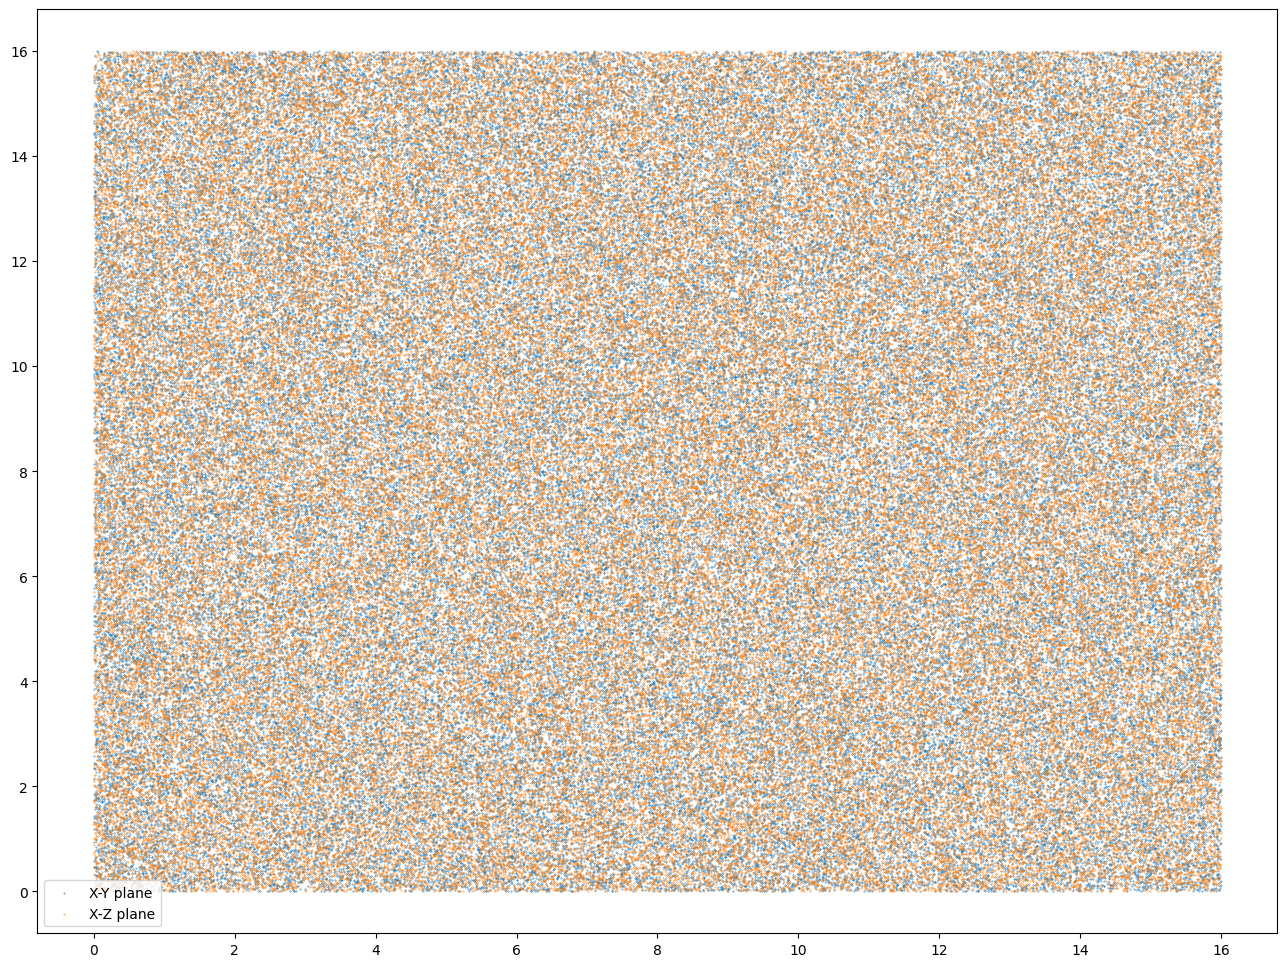

100%|██████████| 2500000/2500000 [25:05<00:00, 1660.90it/s]


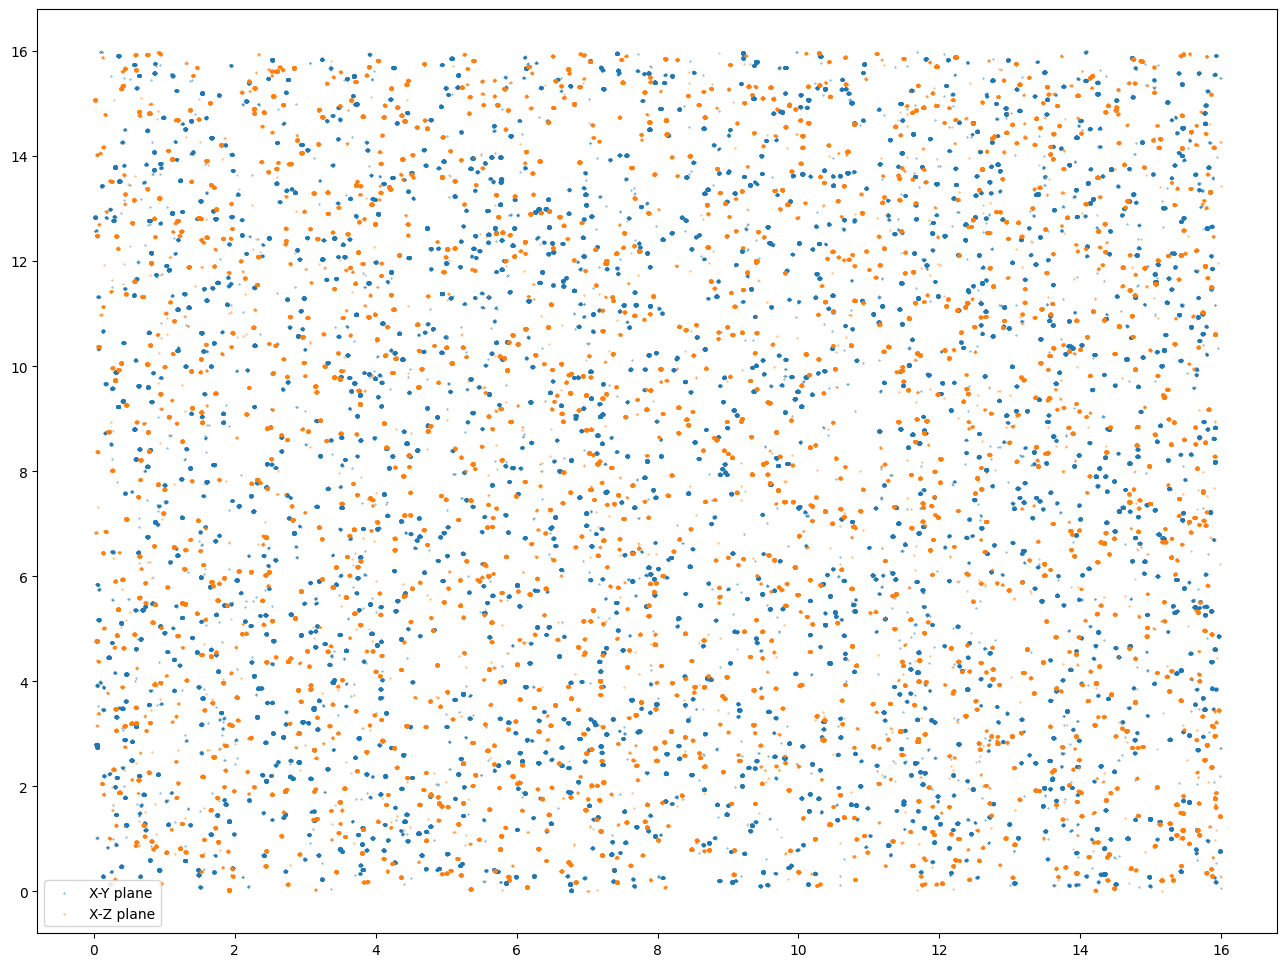

In [39]:
point_radius = 0.01
inv_mass = 1 / 200
temperature = 1.0
k_contact = 8e3
k_damp = 2.0
k_friction = 1.0
k_mu = 0.5
lower_boundary = wp.vec3(0.0, 0.0, 0.0)
length = wp.vec3(16.0, 16.0, 16.0)

points = create_particle_volume(131072, lower_boundary, lower_boundary + length)
speeds = np.sqrt(temperature * inv_mass * 3)
thetas = np.random.rand(len(points)) * 2.0 * np.pi
phis = np.arccos(1 - 2 * np.random.rand(len(points)))
velocities = np.zeros((len(points), 3), dtype=float)
velocities[:, 0] = speeds * np.sin(phis) * np.cos(thetas)
velocities[:, 1] = speeds * np.sin(phis) * np.sin(thetas)
velocities[:, 2] = speeds * np.cos(phis)
speeds = wp.array(speeds, dtype=float)
velocities = wp.array(velocities, dtype=wp.vec3)

forces = wp.empty_like(points)
bounded_pressures = wp.zeros(len(points), dtype=float)
grid = wp.HashGrid(128, 128, 128)
grid_cell_size = 0.125
sim_dt = 0.02
sim_t = 50000.0
plot_pos(points)
pressure = np.zeros(int(sim_t / sim_dt), dtype=float)
pooled_pressures = []
mean_speeds = []
i = pre_i = 0
for t in tqdm(np.linspace(0, sim_t, int(sim_t / sim_dt))):
    grid.build(points, grid_cell_size)
    wp.launch(
            kernel=update,
            dim=points.shape,
            inputs=[
                grid.id,
                points,
                velocities,
                forces,
                point_radius,
                k_contact,
                k_damp,
                k_friction,
                k_mu,
            ],
        )
    wp.launch(
            kernel=integrate_bounce,
            dim=points.shape,
            inputs=[
                points,
                velocities,
                forces,
                bounded_pressures,
                (0.0, 0.0, 0.0),
                sim_dt,
                inv_mass,
                lower_boundary,
                length
            ],
        )
    pressure[i] = wp.to_torch(bounded_pressures).sum().item() / (length[0] * length[1] * 2 + length[1] * length[2] * 2 + length[2] * length[0] * 2)
    if t % 1.0 < sim_dt and i > 0:
        wp.launch(
            kernel=norm_l2,
            dim=points.shape,
            inputs=[
                velocities,
                speeds
            ],
        )
        mean_speeds.append(wp.to_torch(speeds).mean())
        pooled_pressures.append(pressure[pre_i:i+1].mean())
        pre_i = i
    i += 1
plot_pos(points)

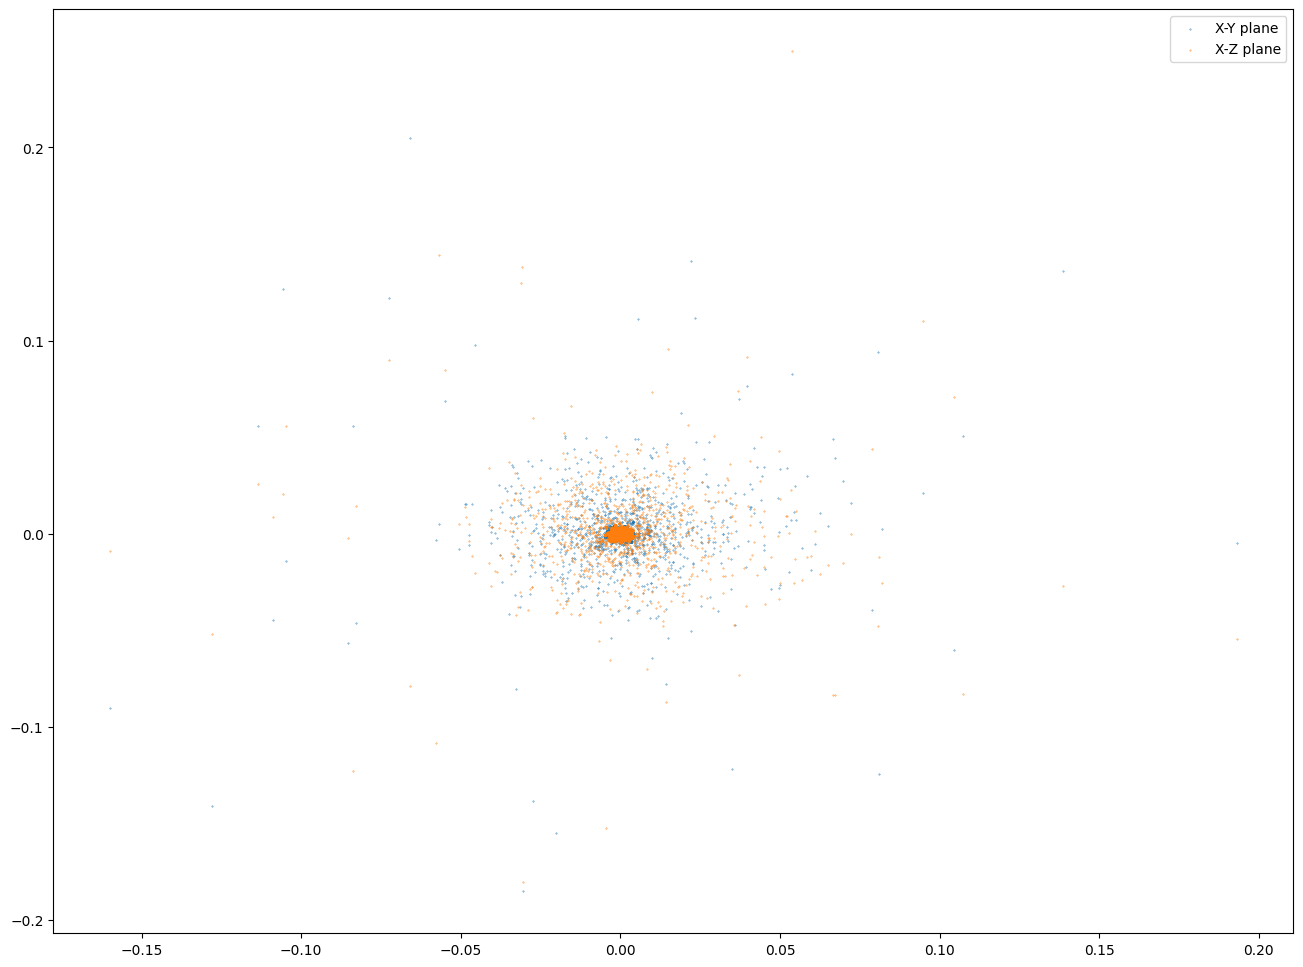

In [40]:
plot_pos(velocities)

In [41]:
velocities

array(shape=(131072,), dtype=vec3f)

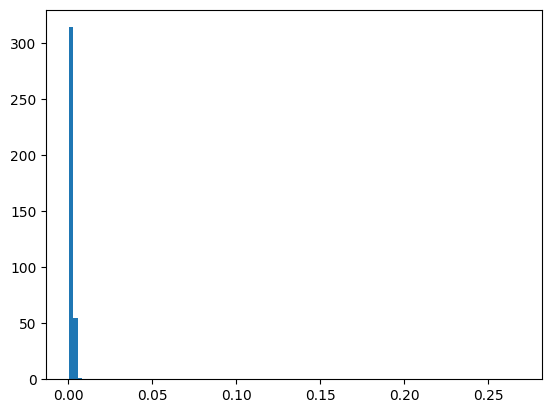

In [42]:
speeds = wp.zeros(len(points), dtype=float)
wp.launch(kernel=norm_l2, inputs=[velocities, speeds], dim=velocities.shape)
plt.hist(speeds.numpy(), bins=100, density=True)
plt.show()

In [43]:

wp.to_torch(bounded_pressures).sum().item() / (length[0] * length[1] * 2 + length[1] * length[2] * 2 + length[2] * length[0] * 2)

0.0

In [44]:
wp.to_torch(bounded_pressures).sum()

tensor(0., device='cuda:0')

In [69]:
len(pooled_pressures)

50000

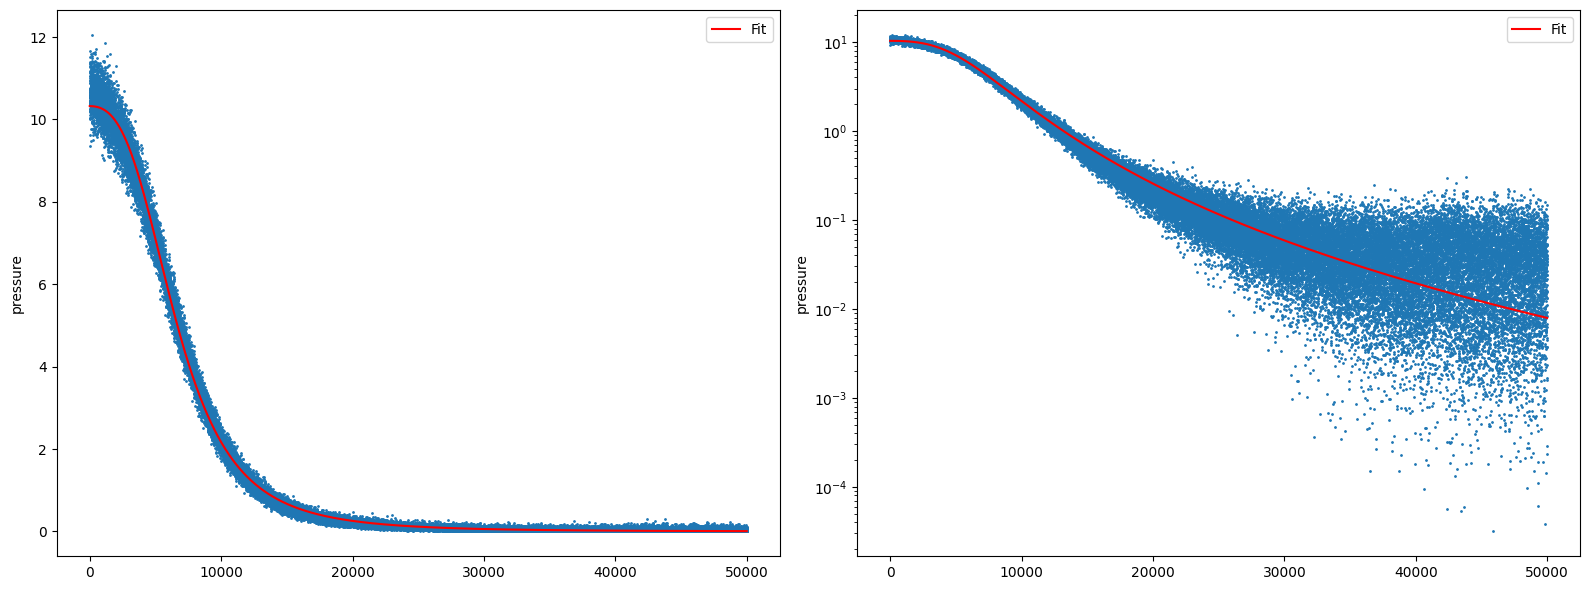

In [110]:
import numpy as np
from scipy.optimize import curve_fit


x_data = np.linspace(0, sim_t, len(pooled_pressures))
y_data = np.array(pooled_pressures)

def decay_func(x, a, b, c):
    return a / (b + np.exp(c * x ** 0.15))

params, _ = curve_fit(decay_func, x_data, y_data, p0=(1, 10, 0.5))
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
axs[0].scatter(x_data, y_data, s=1)
axs[0].plot(x_data, decay_func(x_data, *params), color='red', label='Fit')
axs[0].set_ylabel('pressure')
axs[0].legend()

# Log scale
axs[1].scatter(x_data, y_data, s=1)
axs[1].plot(x_data, decay_func(x_data, *params), color='red', label='Fit')
axs[1].set_yscale('log')
axs[1].set_ylabel('pressure')
axs[1].legend()

plt.tight_layout()
plt.legend()

In [106]:
params

array([ 1.38979639e+01,  3.23956814e-01, -3.86385038e-04,  2.88460378e-04])

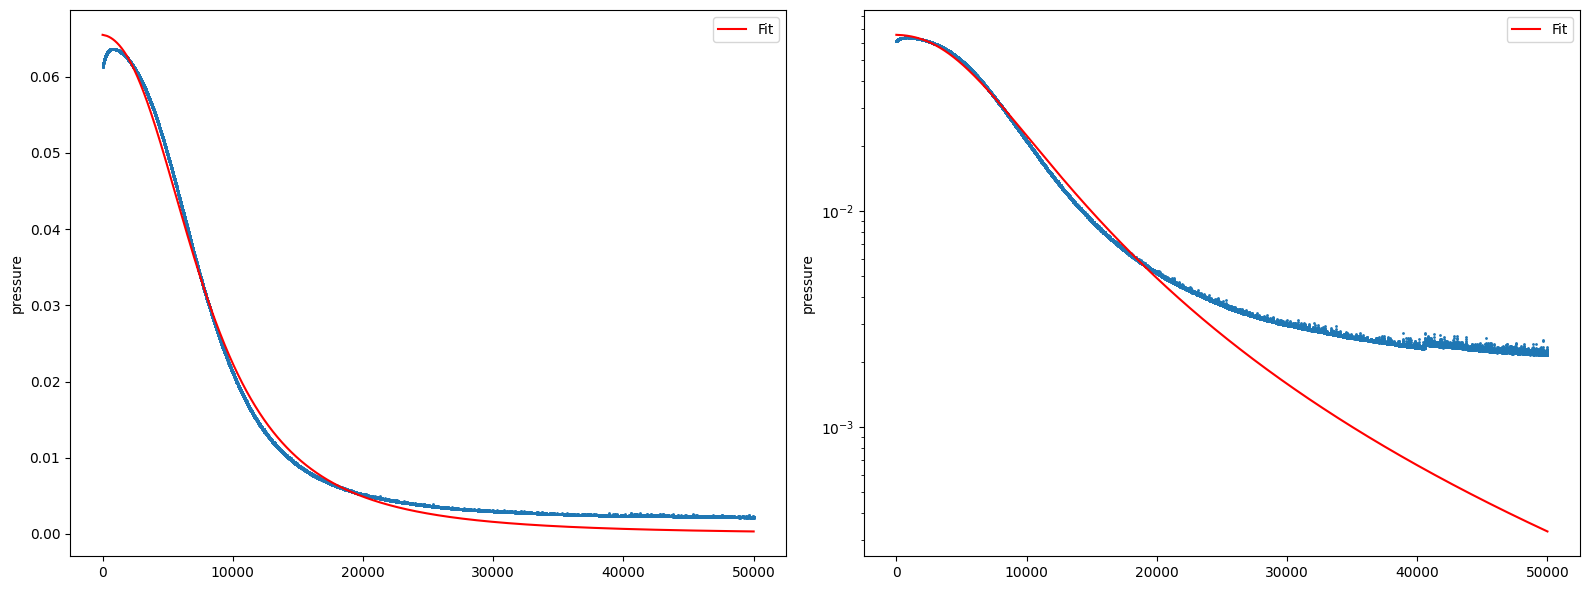

In [112]:
y_data = np.array([v.cpu() for v in mean_speeds])
def decay_func(x, a, b, c):
    return a / (b + np.exp(c * x ** 0.15))

params, _ = curve_fit(decay_func, x_data, y_data, p0=(1, 10, 0.4))
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
axs[0].scatter(x_data, y_data, s=1)
axs[0].plot(x_data, decay_func(x_data, *params), color='red', label='Fit')
axs[0].set_ylabel('pressure')
axs[0].legend()

# Log scale
axs[1].scatter(x_data, y_data, s=1)
axs[1].plot(x_data, decay_func(x_data, *params), color='red', label='Fit')
axs[1].set_yscale('log')
axs[1].set_ylabel('pressure')
axs[1].legend()

plt.tight_layout()
plt.legend()

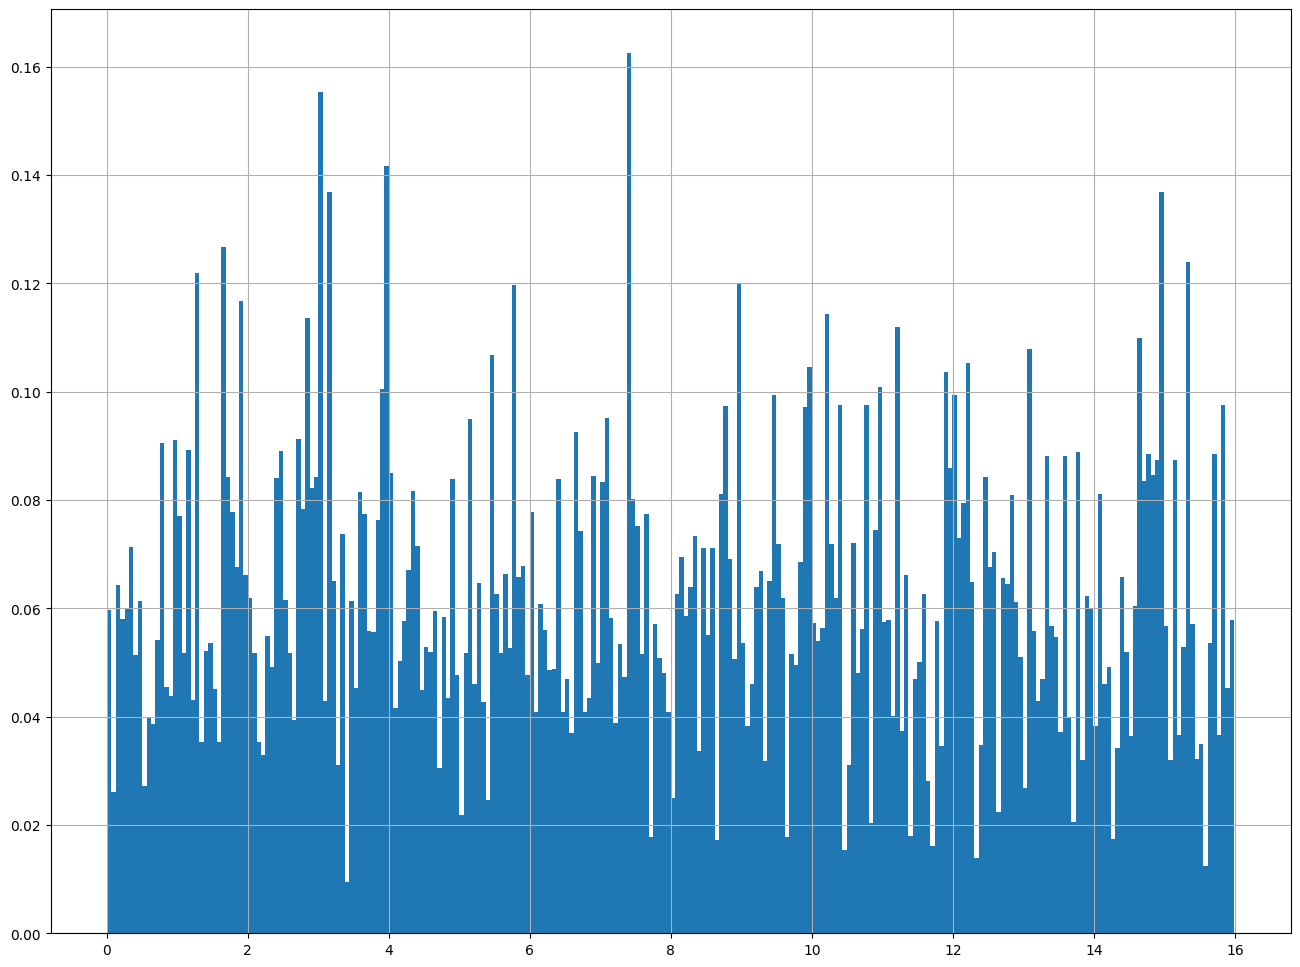

In [47]:
plt.figure(figsize=(16, 12))
plt.hist(points.numpy()[:, 2], bins=256, density=True)
plt.grid()
plt.show()

In [48]:
points.numpy(), points.shape

(array([[ 0.403688 ,  3.4819245,  5.947607 ],
        [12.588687 , 10.62246  , 15.027458 ],
        [ 6.2298074,  1.4028592, 13.295497 ],
        ...,
        [11.915028 ,  3.223175 ,  7.9896007],
        [11.484113 ,  1.7155284, 15.846204 ],
        [12.618005 , 10.630592 , 15.047201 ]], dtype=float32),
 (131072,))

In [49]:
200 * 60 * 64

768000

In [50]:
1 / 60 / 64

0.00026041666666666666

In [51]:
32 ** 3

32768

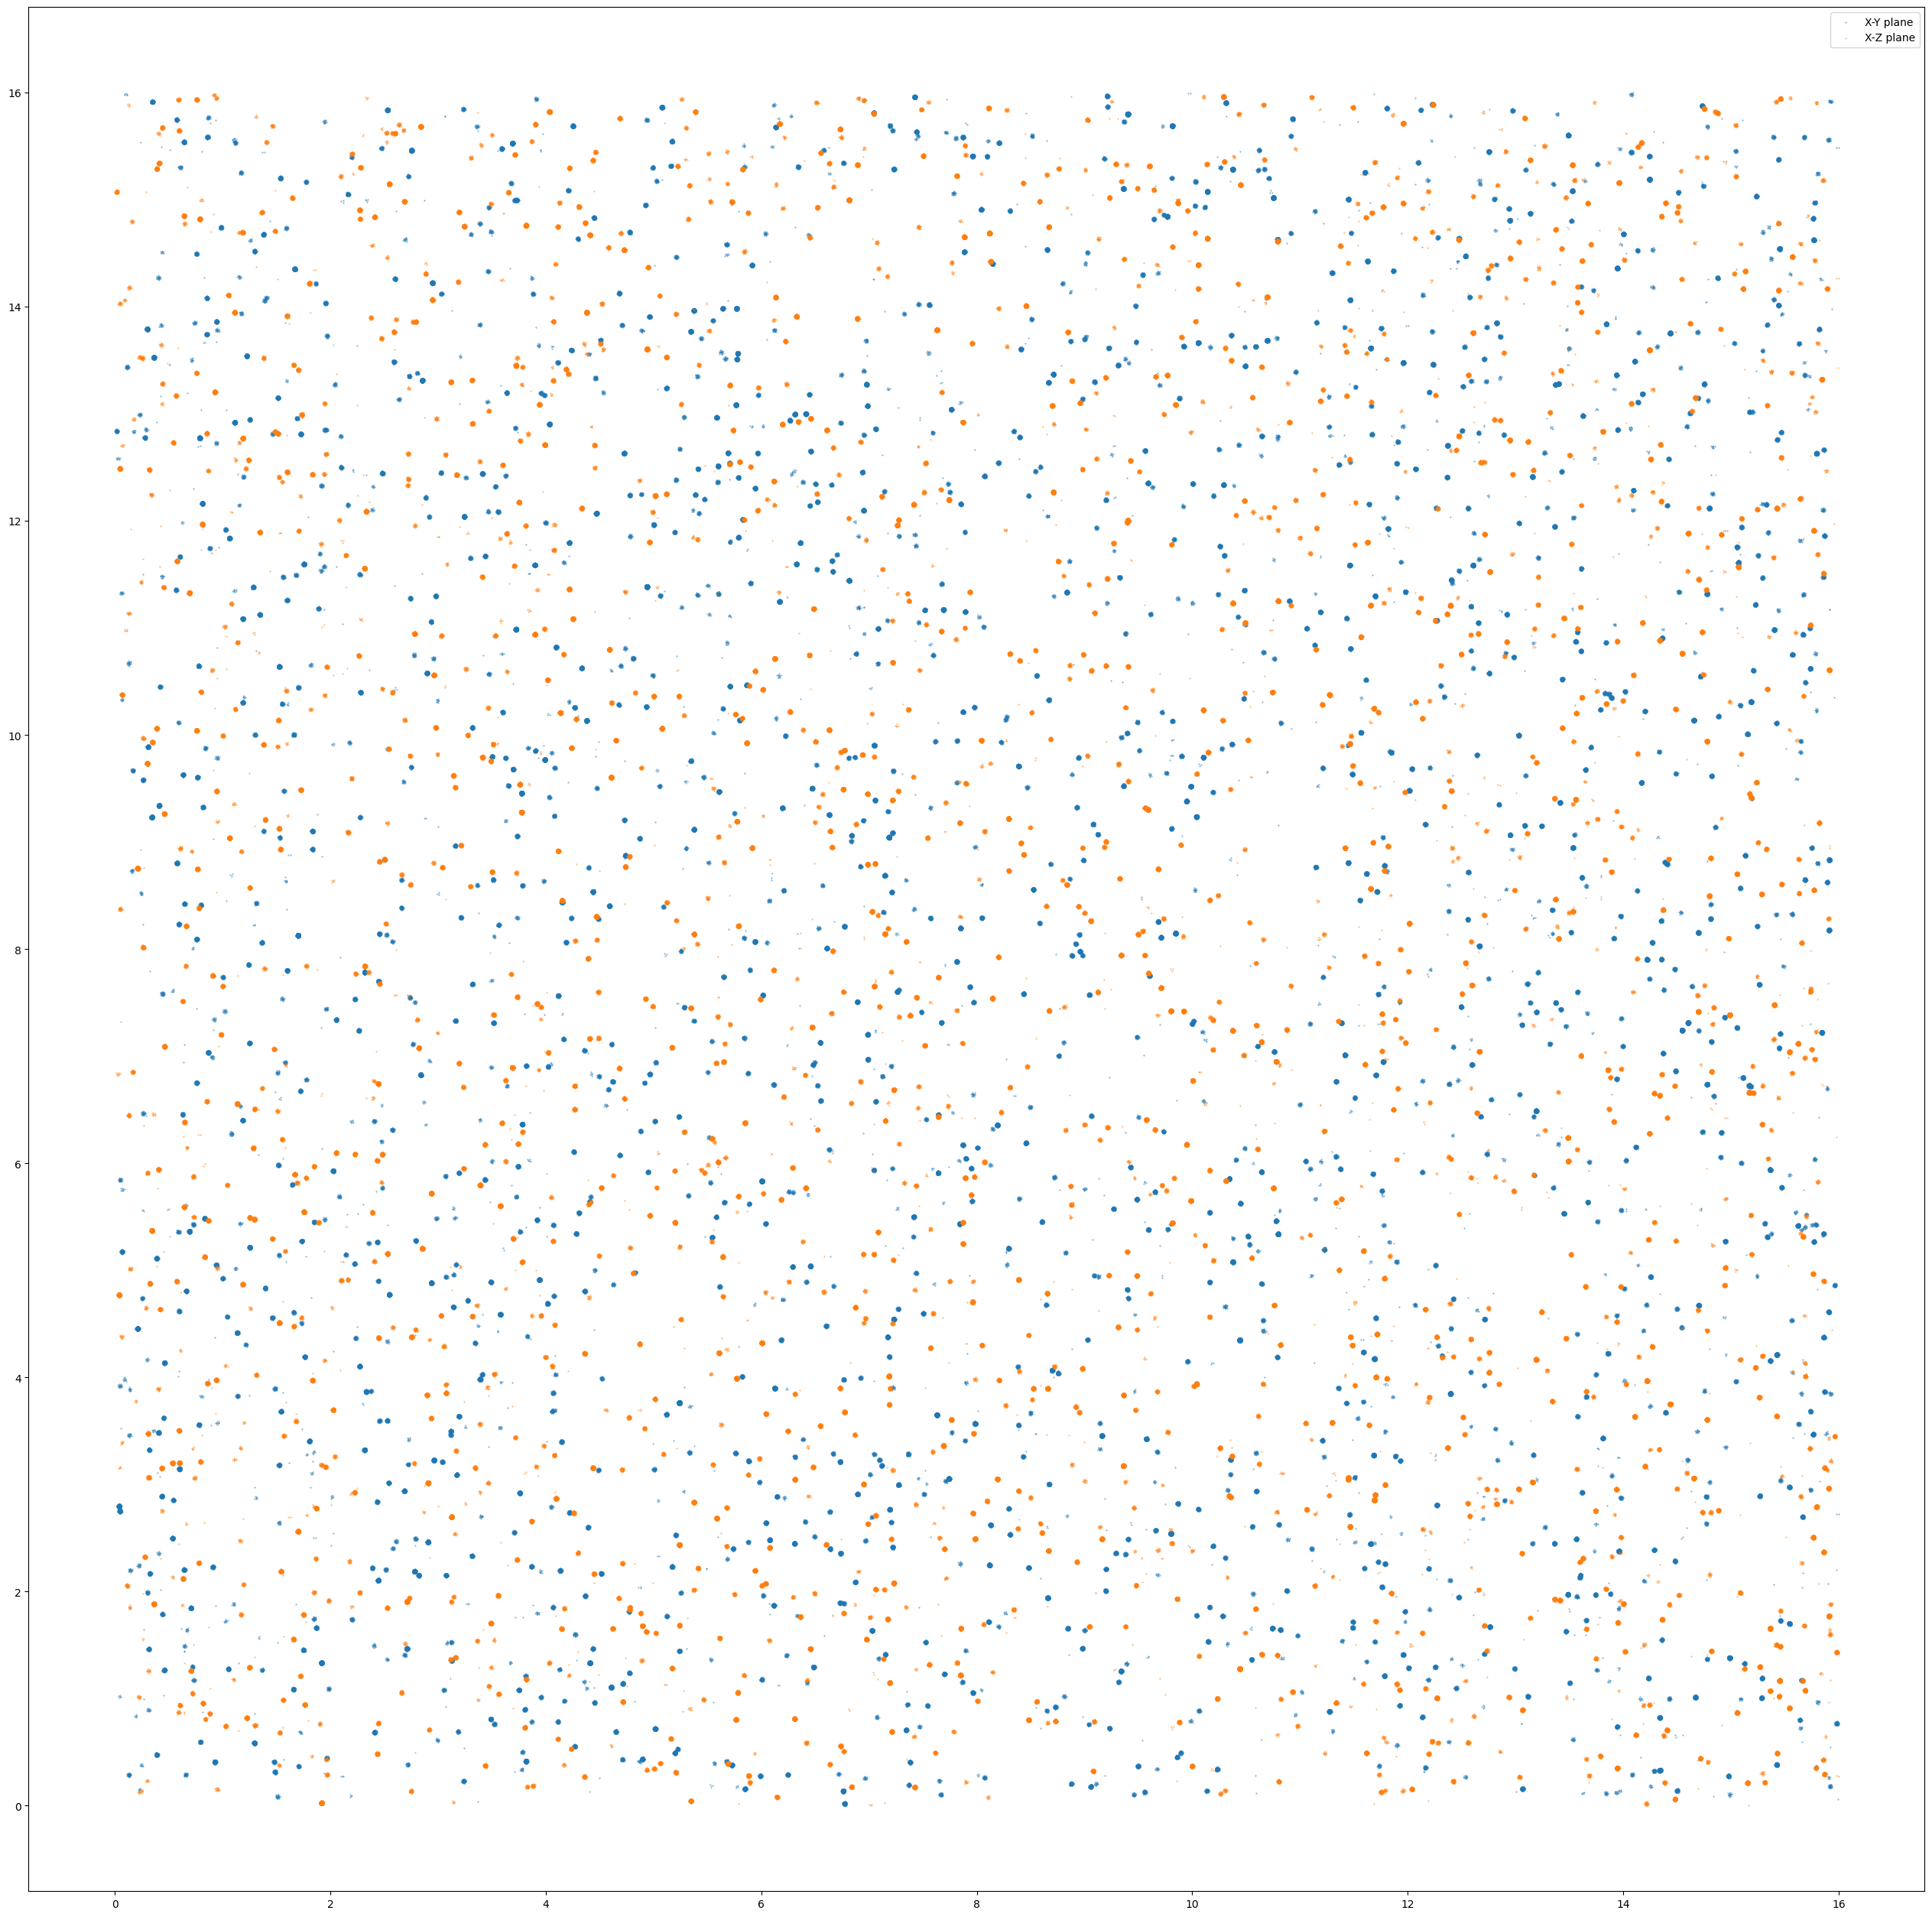

In [52]:
plt.figure(figsize=(32, 32))
plt.scatter(points.numpy()[:, 0], points.numpy()[:, 1], s=0.1, label='X-Y plane')
plt.scatter(points.numpy()[:, 0], points.numpy()[:, 2], s=0.1, label='X-Z plane')
plt.legend()
plt.savefig('points.pdf')